Install & import packages

In [46]:
!pip install --quiet tqdm

In [47]:
!pip install --upgrade pandas

Requirement already up-to-date: pandas in /opt/conda/lib/python3.6/site-packages
Requirement already up-to-date: pytz>=2011k in /opt/conda/lib/python3.6/site-packages (from pandas)
Requirement already up-to-date: python-dateutil>=2 in /opt/conda/lib/python3.6/site-packages (from pandas)
Requirement already up-to-date: numpy>=1.9.0 in /opt/conda/lib/python3.6/site-packages (from pandas)
Requirement already up-to-date: six>=1.5 in /opt/conda/lib/python3.6/site-packages (from python-dateutil>=2->pandas)


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import skewtest, boxcox
from sklearn.base import TransformerMixin, BaseEstimator
from tqdm import tqdm

# Load the data

In [4]:
# raw data
train_raw = pd.read_csv('./train.csv')

In [5]:
train_raw.shape

(595212, 59)

In [6]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

In [7]:
train = pd.read_pickle('./train.pkl')
# test = pd.read_pickle('./test.pkl')

In [8]:
train.shape

(595212, 246)

In [10]:
print('Train dataset has {} rows and {} columns'.format(train.shape[0], train.shape[1]))
# print('Test dataset has {} rows and {} columns'.format(test.shape[0], test.shape[1]))

Train dataset has 595212 rows and 246 columns


Create a combined dataset to deskew, then split out again

In [11]:
target = train['target']
train.drop('target', axis=1, inplace=True)
train.drop('id', axis=1, inplace=True)

In [12]:
print('Train dataset has {} rows and {} columns'.format(train.shape[0], train.shape[1]))
# print('Test dataset has {} rows and {} columns'.format(test.shape[0], test.shape[1]))

Train dataset has 595212 rows and 244 columns


In [13]:
numeric_cols = []
for col in train.columns:
    if '_bin' in col:
        pass
    elif '_cat' in col:
        pass
    else:
        numeric_cols.append(col)
    
        

In [14]:
len(numeric_cols)

26

# Rebalance classes

In [15]:
train.shape

(595212, 244)

In [16]:
print("The number of positvie classes is: {}".format(sum(target)))
print("The number of negative classes is: {}".format(len(target) - sum(target)))
print("The balance percent: {}".format(sum(target) / len(target)))

The number of positvie classes is: 21694
The number of negative classes is: 573518
The balance percent: 0.036447517859182946


In [17]:
target[target==1].shape

(21694,)

In [18]:
combined = pd.concat([train,target], axis=1)

In [19]:
combined[combined['target'] == 1].shape

(21694, 245)

In [20]:
def rebalance(train, target, pos_perc = 0.5, random_state = 42):
    """
    Return a balanced dataset where the positive class is minority
    
    train: 
    target:
    pos_perc: 
    random_state: 
    
    """
    # combine train and target
    combined = pd.concat([train, target], axis=1)
    
    # Minority class
    min_class_sample = combined[combined['target'] == 1]
    
    # Sample equal number 
    maj_class_sample = combined[combined['target']==0].sample(min_class_sample.shape[0])
    
    # Combined balanced into one dataframe
    balanced = pd.concat([maj_class_sample, min_class_sample], axis=0)
    
    # Shuffle the data
    balanced = balanced.sample(frac=1).reset_index(drop=True)
    
    return balanced
    

In [21]:
balanced = rebalance(train, target)

In [22]:
# verify target is balanced
balanced.shape[0]/2 == sum(balanced['target'])

True

In [23]:
target = balanced['target']
balanced.drop('target', axis=1, inplace=True)

In [24]:
print('Train dataset has {} rows and {} columns'.format(balanced.shape[0], balanced.shape[1]))
# print('Test dataset has {} rows and {} columns'.format(test.shape[0], test.shape[1]))

Train dataset has 43388 rows and 244 columns


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     balanced, target, test_size=0.33, random_state=42)


# UMAP projection

In [26]:
!pip install --upgrade llvmlite

Requirement already up-to-date: llvmlite in /opt/conda/lib/python3.6/site-packages


In [27]:
!pip install umap-learn

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [29]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)

In [30]:
import umap
import time

In [ ]:
uboat = umap.UMAP()
start = time.clock()
embedding = uboat.fit_transform(X_train_sc)
end = time.clock()

In [35]:
print('Time taken: {}'.format(end-start))

Time taken: 178.125621


In [36]:
import matplotlib.pyplot as plt

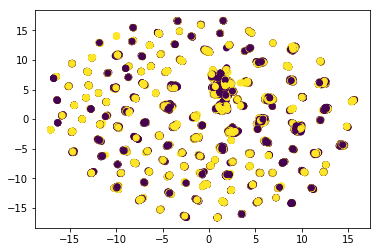

In [37]:
plt.scatter(embedding[:,0], embedding[:,1],c = y_train)

# Models

### SVC

In [52]:
from sklearn.svm import SVC
svc = SVC(probability=True, verbose=True)
start = time.time()
svc.fit(X_train, y_train)
end = time.time()
print("Fit took: {} mins".format((end-start) / 60))

[LibSVM]Fit took: 25.4561612645785 mins


In [53]:
svc.score(X_test,y_test)

0.59228996438298764

## SVC on the Embeddings

In [42]:
embedding.shape

(29069, 2)

In [54]:
from sklearn.svm import SVC
svc_em = SVC(probability=True, verbose=True)
start = time.time()
svc_em.fit(embedding[:20000], y_train[:20000])
end = time.time()
print("Fit took: {} mins".format((end-start) / 60))

[LibSVM]Fit took: 1.8037946661313375 mins


In [56]:
svc_em.score(embedding[20000:], y_train[20000:])

0.54570514941007831

# Metrics

In [77]:
from sklearn.metrics import (classification_report, auc, confusion_matrix, recall_score, 
                             precision_score, roc_curve, roc_auc_score)
from sklearn.metrics import 
from sklearn.metrics import precision_recall_curve

In [60]:
svc_preds = svc.predict_proba(X_test)
svc_em_preds = svc_em.predict_proba(embedding[20000:])

In [74]:
svc_p = svc.predict(X_test)
svc_em_p = svc_em.predict(embedding[20000:])

In [86]:
precision_recall_curve(y_test, svc_p)

(array([ 0.50143166,  0.6030089 ,  1.        ]),
 array([ 1.        ,  0.54707521,  0.        ]),
 array([0, 1]))

In [82]:
2*roc_auc_score(y_test, svc_p) - 1

0.18483960168574587

In [81]:
2*roc_auc_score(y_train[20000:], svc_em_p) - 1

0.092628255611607146

In [84]:
print(classification_report(y_test, svc_p))

             precision    recall  f1-score   support

          0       0.58      0.64      0.61      7139
          1       0.60      0.55      0.57      7180

avg / total       0.59      0.59      0.59     14319



In [85]:
print(classification_report(y_train[20000:], svc_em_p))

             precision    recall  f1-score   support

          0       0.54      0.59      0.56      4471
          1       0.56      0.50      0.53      4598

avg / total       0.55      0.55      0.54      9069

